In [1]:
import time
import numpy as np
import pandas as pd
import json
import seaborn as sb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sb

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import plot_importance
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw

In [2]:
dbname = 'tutor_db'
username = 'codonnell'
pswd = '7883511'

con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM tutor_main
"""
tutor_data = pd.read_sql_query(sql_query,con)
tutor_data.head()

,index,description,hourly_rate,bio,background_check,tut_id,photo,rating_count,rating_av,review_count,...,qual_2,qual_3,sunday_hours,monday_hours,tuesday_hours,wednesday_hours,thursday_hours,friday_hours,saturday_hours,mean_hours
0,0,Fun Experienced Tutor!,60,"['Hi!', ""I'm an experienced tutor with a sense...",1,7269032,1,269,4.98885,15.0,...,Masters,{},0.583333,0.416667,0.583333,0.375000,0.375000,0.583333,0.583333,0.500000
1,1,"Math, Writing and Econ Specialist, 8+ Years Tu...",75,"['From Algebra to MLA, Middle School to MBA, I...",1,7277990,1,338,4.93195,18.0,...,Masters,{},0.500000,0.541667,0.583333,0.583333,0.583333,0.500000,0.333333,0.517857
2,2,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95,"[""I am an experienced (3000+ hours) tutor cert...",1,7611743,1,1046,4.94349,74.0,...,{},{},1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,3,Congratulations to my students entering Harvar...,95,['MARCH 2020: IN ORDER TO ASSIST MORE STUDENTS...,1,7614535,1,1602,4.97940,32.0,...,Masters,{},0.000000,0.375000,0.541667,0.541667,0.250000,0.416667,0.375000,0.357143
4,13,"Patient, Knowledgeable and Effective Spanish T...",125,['I am a high school AP Spanish Language teach...,1,8022035,1,67,4.98507,12.0,...,{},{},0.041667,0.166667,0.083333,0.125000,0.125000,0.083333,0.000000,0.089286


In [3]:
tutor_data = tutor_data.drop_duplicates(subset='tut_id')

In [4]:
tutor_data['log_hourly_rate'] = np.log(tutor_data['hourly_rate'])

In [5]:
def qual_encode(qual):
    
    qual_list = ['Masters','MBA','PhD','J.D.']
    qual_encodings = {'Masters': 1, 'MBA': 1, 'PhD': 2, 'J.D.': 3}
    if qual in qual_list:
        return qual_encodings[qual]
    else:
        return 0

In [6]:
tutor_data['qual_encoded'] = tutor_data.apply(lambda x: qual_encode(x['qual_1']) + qual_encode(x['qual_2']), axis =1) 

In [7]:
cat_features = ['state','qual_encoded']
#num_features = ['rating_count','rating_av','review_count','bio_length',
#               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']
#all_features = ['state','qual_encoded', 'background_check',
#               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']
all_features = ['state','qual_encoded', 'rating_count','rating_av','review_count','bio_length',
               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']
tutors_cb = tutor_data[all_features]

# Use simple label encoding
cbenc = ce.CatBoostEncoder(cols=cat_features, random_state=1)

In [8]:
# Set up feature data and target data
X = tutors_cb.drop('log_hourly_rate', axis=1)
y = tutors_cb['log_hourly_rate']

# Initialise a balanced logisitic regression model
#model_base = XGBRegressor(n_estimators=400, learning_rate=0.01, random_state=1)
model_base = RandomForestRegressor(criterion = 'mae' , random_state=1)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop('state',axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop('state',axis=1)

model_base.fit(train_X.values, train_y.values)

preds_val = model_base.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

15.99546155194375


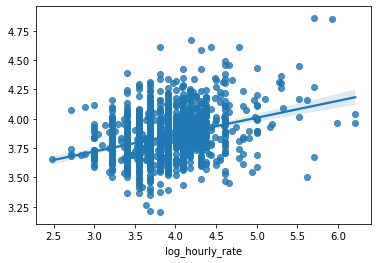

In [9]:
sb.regplot(val_y,preds_val)

In [10]:
r2_score(np.exp(val_y.values),np.exp(preds_val))

0.08838061337865644

In [11]:
stopWords = list(esw) + ['teacher','tutor','tutoring','experience']
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 20000,
    stop_words = stopWords
)
tfidf.fit(tutor_data['description'])
text = tfidf.transform(tutor_data['description'])

In [12]:
description_df = pd.DataFrame(PCA(n_components=2).fit_transform(text.todense()))

In [13]:
tutors_tfidf = tutor_data[all_features].join(description_df).dropna()

In [14]:
len(tutors_tfidf[tutors_tfidf[0].isnull()])

0

In [15]:
# Set up feature data and target data
X = tutors_tfidf.drop('log_hourly_rate', axis=1)
y = tutors_tfidf['log_hourly_rate']

# Initialise a balanced logisitic regression model
model_base = XGBRegressor(n_estimators=600, learning_rate=0.01, random_state=1)
#model_base = RandomForestRegressor(criterion = 'mae' , random_state=1)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop('state',axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop('state',axis=1)

model_base.fit(train_X.values, train_y.values)

preds_val = model_base.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

17.487408694098978


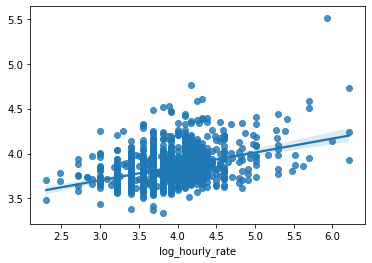

In [16]:
sb.regplot(val_y,preds_val)

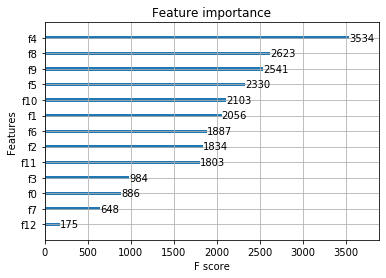

In [17]:
plot_importance(model_base)
plt.show()

In [18]:
sql_query = """
SELECT * FROM tutor_subjects
"""
tutor_subjects = pd.read_sql_query(sql_query,con)
tutor_subjects.head()

,index,tutor_ids,subjects
0,0,7269032,Precalculus
1,1,7269032,French
2,2,7269032,European History
3,3,7269032,Calculus
4,4,7269032,Spanish


In [19]:
tutors_joined = tutor_subjects.groupby('tutor_ids')['subjects'].apply(lambda x: ' '.join(x)).reset_index()

In [20]:
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(float)
tutors_joined['tutor_ids']=tutors_joined['tutor_ids'].apply(int)

In [21]:
stopWords = []
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 20000,
    stop_words = stopWords
)
tfidf.fit(tutors_joined['subjects'])
text = tfidf.transform(tutors_joined['subjects'])

In [22]:
subjects_df = pd.DataFrame(PCA(n_components=2).fit_transform(text.todense()))

In [23]:
tutors_tfidf = tutor_data[all_features].join(subjects_df).dropna()

In [24]:
tutors_tfidf.head()

,state,qual_encoded,rating_count,rating_av,review_count,bio_length,num_subjects,hours_tutoring,edu_length,mean_hours,log_hourly_rate,0,1
0,CA,1,269,4.98885,15.0,376,5,839.0,7,0.500000,4.094345,0.159002,0.165303
1,CA,1,338,4.93195,18.0,323,31,962.0,7,0.517857,4.317488,0.436944,0.130791
2,CA,0,1046,4.94349,74.0,248,72,3899.0,4,1.000000,4.553877,-0.286535,-0.298851
3,CA,1,1602,4.97940,32.0,417,19,5592.0,7,0.357143,4.553877,0.329705,-0.370410
4,CA,0,67,4.98507,12.0,173,5,230.0,4,0.089286,4.828314,0.231302,-0.017491


In [25]:
# Set up feature data and target data
X = tutors_tfidf.drop('log_hourly_rate', axis=1)
y = tutors_tfidf['log_hourly_rate']

# Initialise a balanced logisitic regression model
model_base = XGBRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
#model_base = RandomForestRegressor(criterion = 'mae' , random_state=1)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop('state',axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop('state',axis=1)

model_base.fit(train_X.values, train_y.values)

preds_val = model_base.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

15.731445682902812


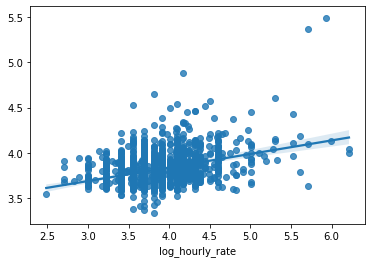

In [26]:
sb.regplot(val_y,preds_val)

In [119]:
cat_features = ['state','qual_encoded']
#num_features = ['rating_count','rating_av','review_count','bio_length',
#               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']

all_features = ['state','qual_encoded', 'rating_count','rating_av','review_count','bio_length',
               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']

tutors_tfidf = tutor_data[all_features].join(subjects_df).dropna()

# Use simple label encoding
cbenc = ce.CatBoostEncoder(cols=cat_features, random_state=1)

In [135]:
tutors_outliers = tutors_tfidf[tutors_tfidf['log_hourly_rate']<5.3]
state_counts = tutors_outliers['state'].value_counts().reset_index()
tutor_out_state = pd.merge(tutors_outliers, state_counts, left_on = 'state', right_on = 'index').drop('index',axis=1)
tutor_out_state['state_y']=tutor_out_state['state_y'].rdiv(1)

In [136]:
cat_features = ['state_x','qual_encoded']
#num_features = ['rating_count','rating_av','review_count','bio_length',
#               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate']

all_features = ['state','qual_encoded', 'rating_count','rating_av','review_count','bio_length',
               'num_subjects','hours_tutoring','edu_length','mean_hours','log_hourly_rate',0,1,'state_y']

# Use simple label encoding
cbenc = ce.CatBoostEncoder(cols=cat_features, random_state=1)

In [137]:
# Set up feature data and target data
X = tutor_out_state.drop('log_hourly_rate', axis=1)
y = tutor_out_state['log_hourly_rate']

# Initialise a balanced logisitic regression model
model_base = XGBRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
#model_base = RandomForestRegressor(criterion = 'mae' , random_state=1)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop('state_x',axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop('state_x',axis=1)

model_base.fit(train_X.values, train_y.values)

preds_val = model_base.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

14.548551185480601


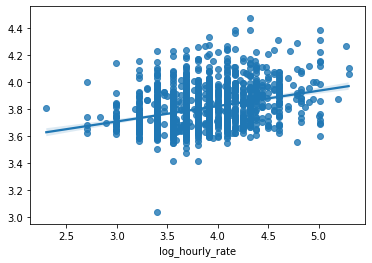

In [134]:
sb.regplot(val_y,preds_val)

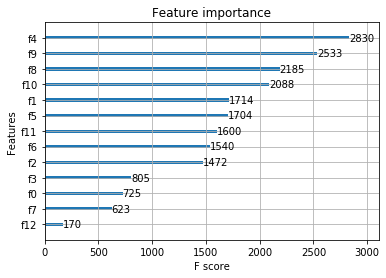

In [31]:
plot_importance(model_base)
plt.show()

In [32]:
stopWords = list(esw) + ['teacher','tutor','tutoring','experience']
tfidf_bio = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 20000,
    stop_words = stopWords
)
tfidf_bio.fit(tutor_data['bio'])
text_bio = tfidf_bio.transform(tutor_data['bio'])

In [37]:
bio_df = pd.DataFrame(PCA(n_components=2).fit_transform(text_bio.todense()))
tutors_biotfidf = tutor_data[all_features].join(bio_df).dropna()
tutors_biotfidf = tutors_biotfidf[tutors_biotfidf['log_hourly_rate']<5.3]

In [38]:
# Set up feature data and target data
X = tutors_biotfidf.drop('log_hourly_rate', axis=1)
y = tutors_biotfidf['log_hourly_rate']

# Initialise a balanced logisitic regression model
model_base = XGBRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
#model_base = RandomForestRegressor(criterion = 'mae' , random_state=1)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop('state',axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop('state',axis=1)

model_base.fit(train_X.values, train_y.values)

preds_val = model_base.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

13.884577755246843


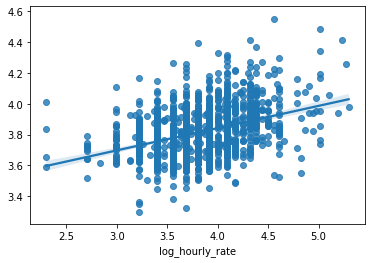

In [39]:
sb.regplot(val_y,preds_val)

In [49]:
#tutors_bio_subjects = tutors_tfidf.join(bio_df)
bio_df = bio_df.rename(columns={0: 'bio_0',1: 'bio_1'})

In [51]:
tutors_bio_subjects = tutors_tfidf.join(bio_df, how='left')

In [116]:
tutors_bio_subjects = tutors_bio_subjects[tutors_bio_subjects['log_hourly_rate']<5.3].dropna()

In [118]:
# Set up feature data and target data
X = tutors_bio_subjects.drop('log_hourly_rate', axis=1)
y = tutors_bio_subjects['log_hourly_rate']

# Initialise a balanced logisitic regression model
model_base = XGBRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
#model_base = RandomForestRegressor(criterion = 'mae' , random_state=1)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop('state',axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop('state',axis=1)

model_base.fit(train_X.values, train_y.values)

preds_val = model_base.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

13.897486280713762


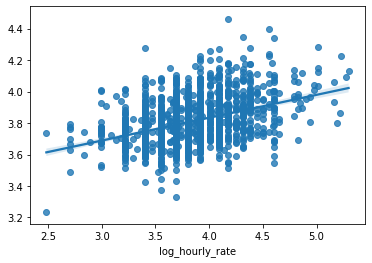

In [55]:
sb.regplot(val_y,preds_val)

In [65]:
tutor_data['hours_tutoring'].sum()

2083635.0

In [138]:
len(val_y)

1678

In [73]:
tutor_subjects['tutor_ids']=tutor_subjects['tutor_ids'].apply(float)
tutor_subjects['tutor_ids']=tutor_subjects['tutor_ids'].apply(int)
tut_hours = pd.merge(tutor_subjects, tutor_data, left_on = 'tutor_ids', right_on = 'tut_id')[['subjects','hours_tutoring']]

In [78]:
tut_hours.groupby('subjects').sum().sort_values(by='hours_tutoring',ascending=False)

,hours_tutoring
subjects,
Algebra 1,1962447.0
Prealgebra,1816177.0
Algebra 2,1797808.0
Geometry,1683441.0
SAT Math,1652997.0
...,...
Harp,2111.0
Tango,1910.0
Thai,1758.0


In [97]:
states_counted = tutors_bio_subjects['state'].value_counts().reset_index()
states200 = states_counted[states_counted['state']>200]['index'].values
tutors200 = tutors_bio_subjects[tutors_bio_subjects['state'].isin(states200)]

In [114]:
# Set up feature data and target data
X = tutors200.drop('log_hourly_rate', axis=1)
y = tutors200['log_hourly_rate']

# Initialise a balanced logisitic regression model
#model_base = XGBRegressor(n_estimators=500, learning_rate=0.01, random_state=1)
#model_base = RandomForestRegressor(criterion = 'mae' , random_state=1)
#model_base = lgb.LGBMRegressor(n_estimators=100)

# Perform feature normalisation
#scaler = StandardScaler()

# Split into 80% training, 20% test
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state = 1)

cbenc.fit(train_X[cat_features], train_y)

train_X = train_X.join(cbenc.transform(train_X[cat_features]).add_suffix('_cb'))
train_X = train_X.drop('state',axis=1)
val_X = val_X.join(cbenc.transform(val_X[cat_features]).add_suffix('_cb'))
val_X = val_X.drop('state',axis=1)

model_base.fit(train_X.values, train_y.values)

preds_val = model_base.predict(val_X.values)
mae = mean_absolute_error(np.exp(val_y.values), np.exp(preds_val))
#mae = mean_absolute_error(val_y.values, preds_val)
print(mae)

14.38582904685597


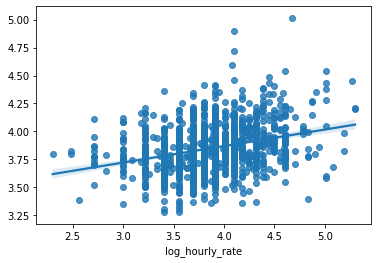

In [111]:
sb.regplot(val_y,preds_val)

In [104]:
import lightgbm as lgb

In [ ]:
model = LGBMRegressor()
model.fit(X, y)
# make a single prediction

yhat = model.predict(row)
print('Prediction: %.3f' % yhat[0])